# Using Transformers for addition

In [1]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from math import sqrt

Populating the interactive namespace from numpy and matplotlib


## Building the dataset

In [2]:
x, y = [], []
# full dataset adds up to 99 + 99
for a in range(100):
    for b in range(100):
        c = a + b
        # build numbers in single digits (23 -> 2,3)
        x.append([a//10, a%10, b//10, b%10])
        # reverse target digits to make addition more easy for the network
        y.append(list(reversed([c//100, (c%100)//10, c%10])))
# to tensors
x, y = torch.LongTensor(x), torch.LongTensor(y)
# split in training and testing dataset
n = int(len(x) * 0.8)
x_train, y_train = x[:n], y[:n]
x_test, y_test = x[n:], y[n:]
# create datasets
train_data = torch.utils.data.TensorDataset(x_train, y_train)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=32)

## Model

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, attention_heads):
        nn.Module.__init__(self)
        # dimensions
        assert (hidden_dim % attention_heads) == 0
        self.h, self.hidden = attention_heads, hidden_dim
        self.d = hidden_dim // attention_heads
        # linear layers
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.comb = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, k, q, v):
        # apply linear layers
        k = self.key(k)
        v = self.value(v)
        q = self.query(q)
        # split attention heads
        b, s, _ = k.size()
        k = k.reshape(b, s, self.h, self.d).permute(0, 2, 1, 3)
        q = q.reshape(b, s, self.h, self.d).permute(0, 2, 3, 1)
        v = v.reshape(b, s, self.h, self.d).permute(0, 2, 3, 1)
        # scaled dot-product attention
        score = torch.softmax((q @ k) / sqrt(self.d), dim=-1)
        att = (score @ v).permute(0, 3, 1, 2)
        # concatenate attention heads
        att = att.reshape(b, s, self.h * self.d)
        att = self.comb(att)
        return att
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, attention_heads):
        nn.Module.__init__(self)
        # sub modules
        self.attention = MultiHeadAttention(hidden_dim, attention_heads)
        self.ff = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # layer norms
        self.ln_1 = nn.LayerNorm(hidden_dim)
        self.ln_2 = nn.LayerNorm(hidden_dim)
    def forward(self, x):
        x = self.ln_1(self.attention(x, x, x) + x)
        x = self.ln_2(self.ff(x) + x)
        return x
class Transformer(nn.Module):
    def __init__(self, num_layers, vocab_size, seq_length, hidden_dim, attention_heads):
        nn.Module.__init__(self)
        # embeddings
        self.embedd = nn.Embedding(vocab_size, hidden_dim)
        self.pos_embedd = nn.Embedding(seq_length, hidden_dim)
        # transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(hidden_dim, attention_heads) for _ in range(num_layers)
        ])
        # prediction layer
        self.classifier = nn.Linear(hidden_dim, vocab_size)
    def forward(self, ids):
        # embedd input ids
        pos_ids = torch.arange(ids.size(1)).unsqueeze(0).to(ids.device)
        x = self.embedd(ids) + self.pos_embedd(pos_ids)
        # pass through attention layers
        for l in self.layers:
            x = l(x)
        # compute prediction
        x = self.classifier(x)
        return x

In [4]:
# use gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# create model
model = Transformer(
    num_layers=2,
    vocab_size=10,
    seq_length=6,
    hidden_dim=128,
    attention_heads=4,
).to(device)
# count number of parameters
n_params = np.sum(np.fromiter((p.numel() for p in model.parameters() if p.requires_grad), dtype=int))
print("Number of Parameters:", n_params)
# create optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

Using device: cuda:0
Number of Parameters: 169482


## Training

In [5]:
epochs = 7
losses = []
model.train()
# tqdm
with tqdm(total=epochs * len(train_loader)) as t:
    t.set_description("Train")
    # actual training loop
    for e in range(epochs):
        for in_ids, out_ids in train_loader:
            # build actual input and output
            ids = torch.cat((in_ids, out_ids), dim=1).to(device)
            l = 0
            # predict all digits one at a time
            for i in range(4):
                x, y_hat = ids[:, :3+i], ids[:, 1:3+i+1]
                # predict and compute loss
                y = model(x).flatten(start_dim=0, end_dim=1)
                l += F.cross_entropy(y, y_hat.flatten())
            # update parameters
            optim.zero_grad()
            l.backward()
            optim.step()
            # save/show progress
            losses.append(l.item())
            t.set_postfix({'loss': sum(losses[-100:]) / min(len(losses), 100)})
            t.update(1)

Train: 100%|██████████| 1750/1750 [00:44<00:00, 39.07it/s, loss=0.803]


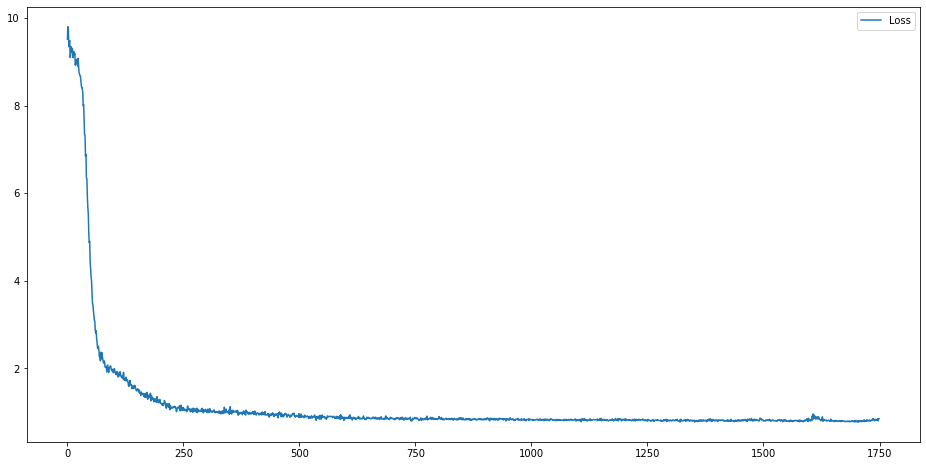

In [6]:
# plot losses
figsize(16, 8)
figure()
plot(losses)
legend(["Loss"])
show()

## Testing

In [7]:
model.eval()
# prepare input
ids = torch.cat((x_test, y_test), dim=1).to(device)
for i in range(3):
    x, y_hat = ids[:, :4+i], ids[:, 1:4+i+1]
    # predict
    y = model(x)
    y = torch.argmax(y, dim=-1)
    # TODO: currently only considering last digit (as in training)
    hits = (y_hat[:, -1] == y[:, -1]).sum().item()
    acc = hits / ids.size(0)
    print("Digit-%i Accuracy: %f" % (i+1, acc))

Digit-1 Accuracy: 0.999500
Digit-2 Accuracy: 0.848500
Digit-3 Accuracy: 1.000000


In [8]:
# add up two numbers
a, b = 84, 67
out = []
# prepare input
ids = torch.LongTensor([[a // 10, a % 10, b // 10, b % 10]]).to(device)
# predict all three possible output digits
for i in range(3):
    c = model(ids).argmax(dim=-1)
    ids = torch.cat((ids, c[:, -1:]), dim=1)
    out.append(c[0, -1].item())
# combine output
c = int(''.join(map(str, reversed(out))))
print("%i + %i = %i (%i)" % (a, b, c, a+b))

99 + 99 = 198 (198)
